# NLP-Driven Sentiment Prediction on Corporate Reviews: A Hybrid ML-DL Approach

### Importing Lib

In [ ]:
import re
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, mean_absolute_error


In [ ]:
warnings.filterwarnings("ignore")
plt.style.use('dark_background')

In [ ]:
# Text data is vectorized using TF-IDF to convert words into numerical features.
class CFG:
    SEED = 768
    BATCH_SIZE = 32
    EPOCHS = 10

In [ ]:
# Random seeds are fixed across libraries to ensure consistent and reproducible model results.
def seed_everything(seed=CFG.SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(CFG.SEED)

## Dataset Exploration

In [ ]:
from google.colab import files
import pandas as pd

# Upload files
uploaded = files.upload()  # Select your train.csv, test.csv, and sample_submission.csv

# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv
Train shape: (60000, 3)
Test shape: (40000, 2)


In [ ]:
# Generate summary of the training set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      60000 non-null  int64 
 1   Review  60000 non-null  object
 2   Rating  60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [ ]:
# View first 5 training samples
train.head(5)

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


# Data Cleaning Function


In [ ]:

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

import string # Import the string module

def clean_text(text):
    text = str(text).lower()                                 # Lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)        # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)                    # Remove mentions & hashtags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)                          # Remove numbers
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Apply cleaning
train['clean_text'] = train['Review'].apply(clean_text) # Use 'Review' instead of 'text'
test['clean_text'] = test['Review'].apply(clean_text)   # Use 'Review' instead of 'text'

print("✅ Cleaned sample text:")
print(train['clean_text'].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


✅ Cleaned sample text:
0    good value great tv happy delivery next day fr...
1                      month still cant access account
2    couldnt make official review product app came ...
3    fantastic extremely easy use website fantastic...
4    far annoyed hell bt monthly pas easy abc get a...
Name: clean_text, dtype: object


### TF-IDF feature vectors

In [ ]:
# This code converts company review text into numerical TF-IDF feature vectors, enabling further analysis or modeling.

#Create sample data
# Sample processed data (replace this with your processed DataFrame)
data = {
    'Review': [
        'good value great tv happy',
        'month still cannot access account',
        'fantastic extremely easy website',
        'annoyed monthly payment plan'
    ],
    'Rating': [5, 2, 5, 1]
}
df = pd.DataFrame(data)

from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['Review'])

# Convert to DataFrame for easier handling
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

print("TF-IDF Features:")
print(tfidf_df.head())

TF-IDF Features:
    access  account  annoyed  easy  extremely  fantastic      good     great  \
0  0.00000  0.00000      0.0   0.0        0.0        0.0  0.447214  0.447214   
1  0.57735  0.57735      0.0   0.0        0.0        0.0  0.000000  0.000000   
2  0.00000  0.00000      0.0   0.5        0.5        0.5  0.000000  0.000000   
3  0.00000  0.00000      0.5   0.0        0.0        0.0  0.000000  0.000000   

      happy    month  monthly  payment  plan        tv     value  website  
0  0.447214  0.00000      0.0      0.0   0.0  0.447214  0.447214      0.0  
1  0.000000  0.57735      0.0      0.0   0.0  0.000000  0.000000      0.0  
2  0.000000  0.00000      0.0      0.0   0.0  0.000000  0.000000      0.5  
3  0.000000  0.00000      0.5      0.5   0.5  0.000000  0.000000      0.0  


# Data Visualization

Rating Distribution

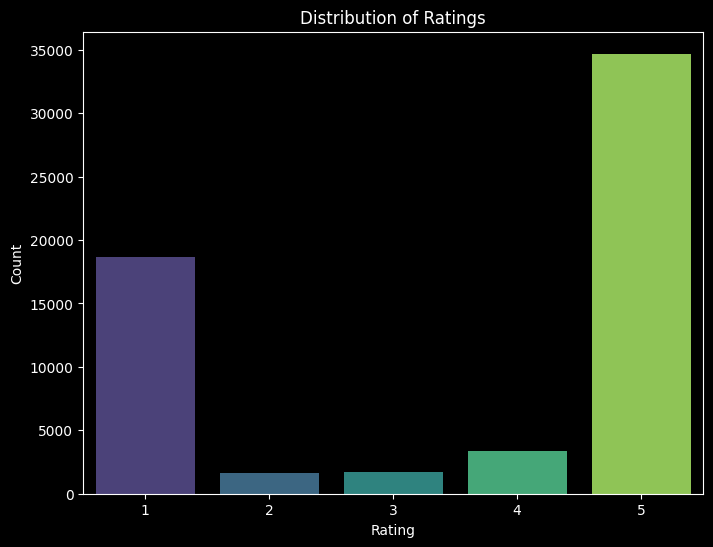

In [ ]:
# Plot the distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='Rating', data=train, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Word Cloud of Cleaned Reviews

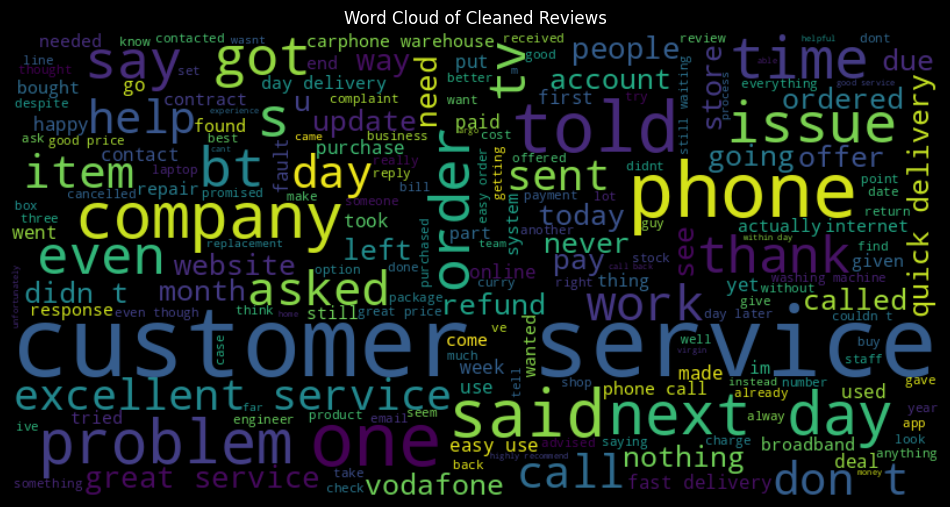

In [ ]:

all_cleaned_text = ' '.join(train['clean_text'].dropna())

wordcloud = WordCloud(width=800, height=400, random_state=CFG.SEED, max_font_size=110, background_color='black').generate(all_cleaned_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud of Cleaned Reviews')
plt.show()

# PCA to reduce dimensions

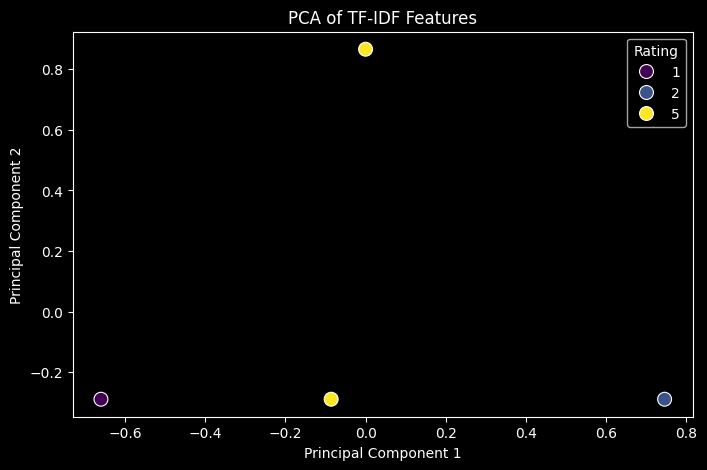

In [ ]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_df)

# Visualize PCA result
plt.figure(figsize=(8, 5))
sns.scatterplot(x=reduced_features[:,0], y=reduced_features[:,1], hue=df['Rating'], palette='viridis', s=100)
plt.title('PCA of TF-IDF Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Rating')
plt.show()

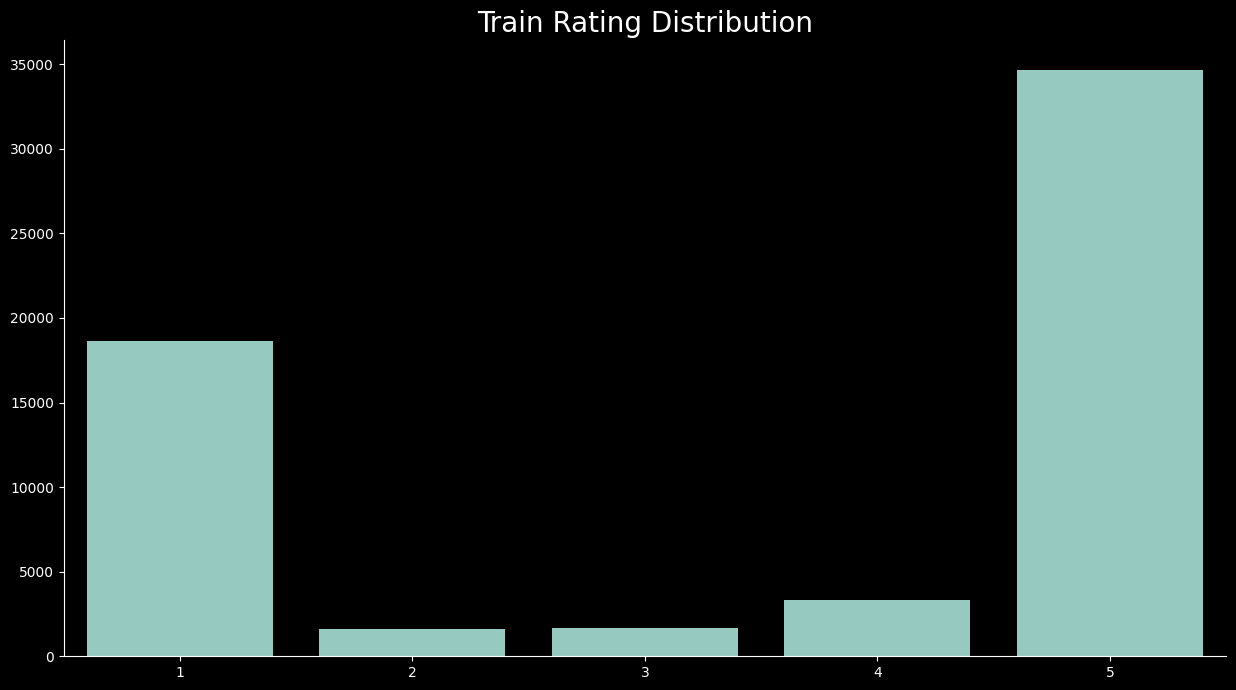

In [ ]:
# Visualized the distribution of sentiment ratings in the training dataset using a bar chart to identify class imbalance.

plt.figure(figsize=(15, 8))
plt.title('Train Rating Distribution', fontsize=20)

train_distribution = train['Rating'].value_counts().sort_values()
sns.barplot(x=list(train_distribution.keys()),
            y=train_distribution.values);

sns.despine();

### Inspect Review Lengths & Tokens

In [ ]:
# Calculated and analyzed review lengths and token counts
# to understand text size variation and guide preprocessing and model input length decisions.

# Get the lengths of each review
train['review_length'] = [len(_) for _ in train.Review]

# Get the number of tokens per review
train['token_count'] = [len(_.split()) for _ in train.Review]

In [ ]:

train.head(5)

,Id,Review,Rating,clean_text,review_length,token_count
0,0,Very good value and a great tv very happy and ...,5,good value great tv happy delivery next day fr...,89,18
1,1,After 6 month still can't access my account,3,month still cant access account,43,8
2,2,I couldn't make an official review on a produc...,1,couldnt make official review product app came ...,496,92
3,3,"Fantastic! Extremely easy to use website, fant...",5,fantastic extremely easy use website fantastic...,197,32
4,4,So far annoyed as hell with this bt monthly pa...,1,far annoyed hell bt monthly pas easy abc get a...,222,49


In [ ]:
# Inspect Review Length Stats
print('Review Length Description')
print('==================================')
print(train['review_length'].describe())
print('==================================')

Review Length Description
count    60000.000000
mean       309.070083
std        423.772492
min         31.000000
25%         82.000000
50%        164.000000
75%        358.000000
max       7794.000000
Name: review_length, dtype: float64


In [ ]:
# Inspect Token Count Stats
print('Token Count Description')
print('==================================')
print(train['token_count'].describe())
print('==================================')

Token Count Description
count    60000.00000
mean        56.56325
std         79.35289
min          1.00000
25%         14.00000
50%         29.00000
75%         66.00000
max       1439.00000
Name: token_count, dtype: float64


### To understand how review length and word count vary across different sentiment ratings.

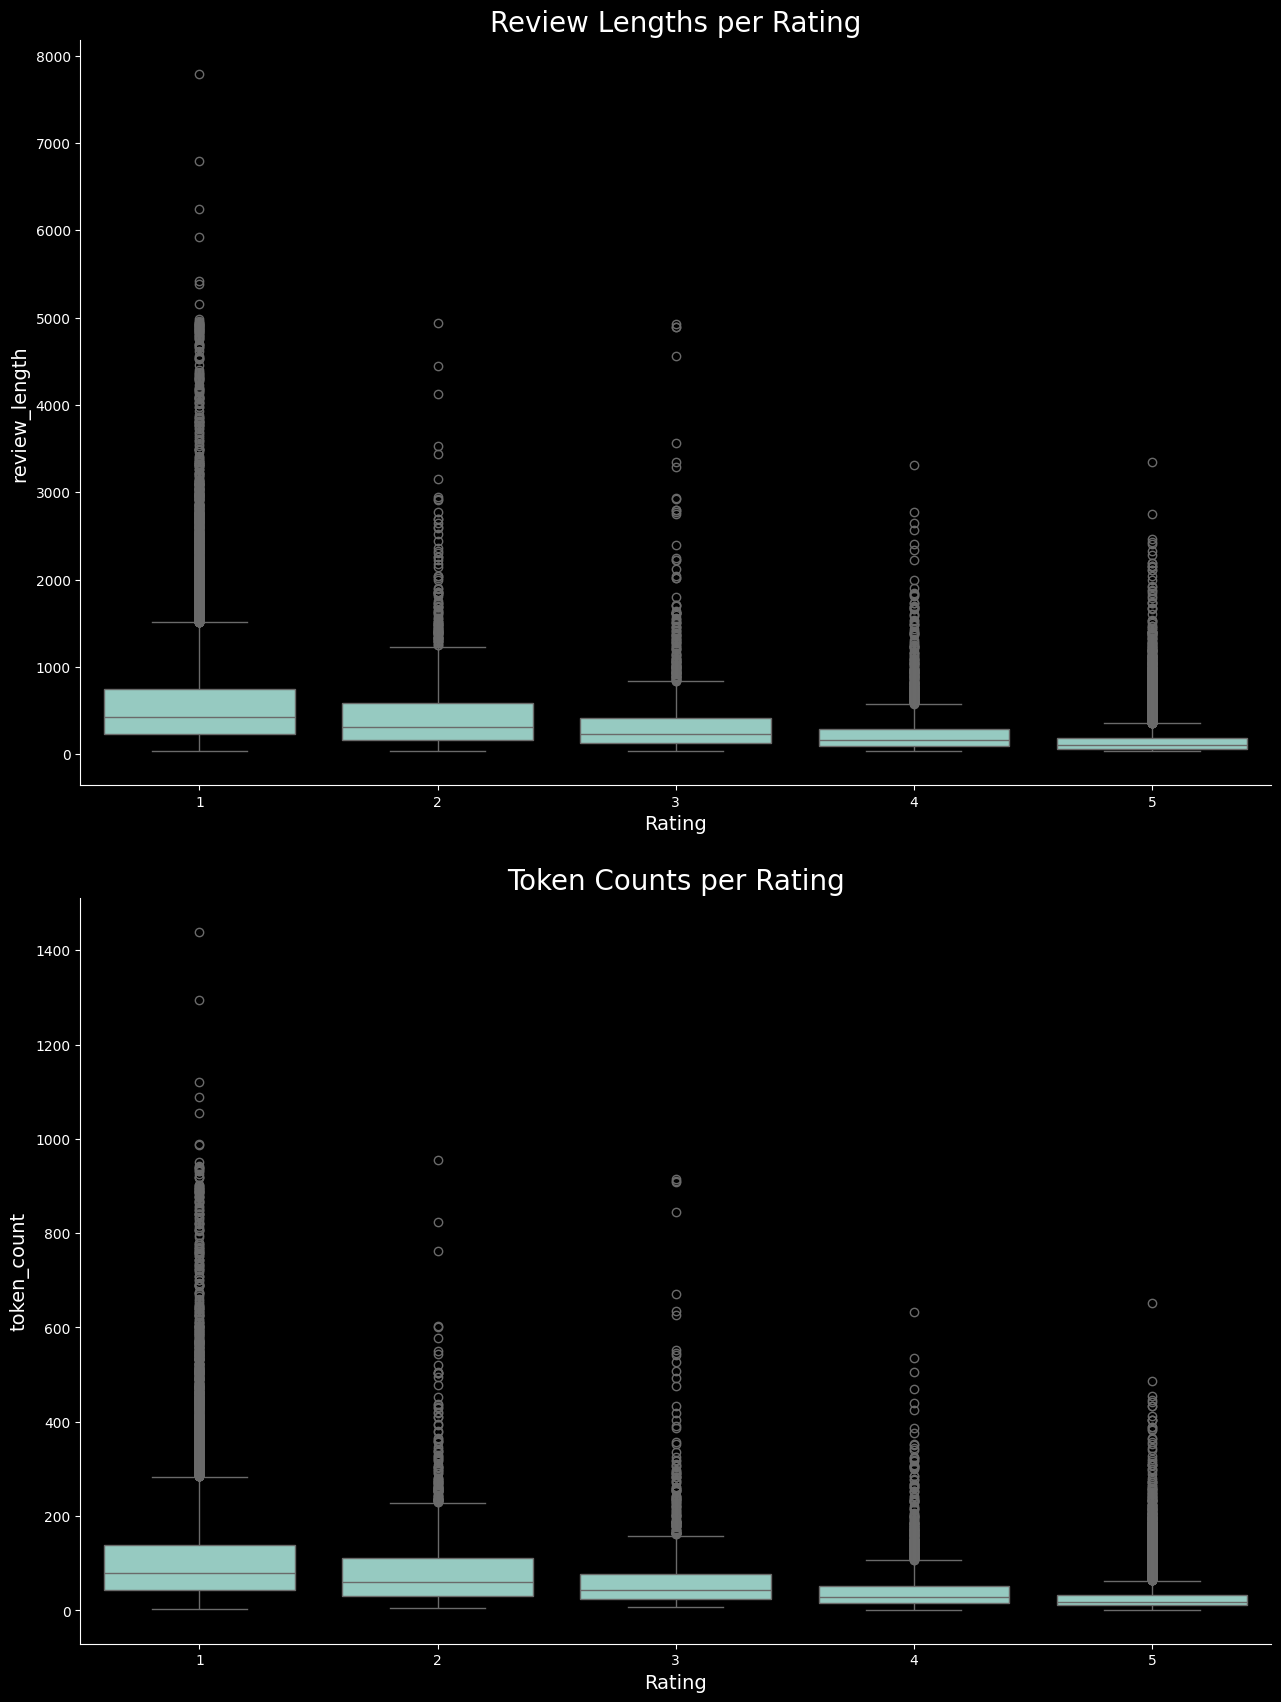

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 18))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Range of Review Lengths per Rating
ax1.set_title('Review Lengths per Rating', fontsize=20)
sns.boxplot(data=train, y='review_length', x='Rating',
            ax=ax1)
ax1.set_xlabel('Rating', fontsize=14)
ax1.set_ylabel('review_length', fontsize=14)
sns.despine();

# Plot Range of Token Counts per Rating
ax2.set_title('Token Counts per Rating', fontsize=20)
sns.boxplot(data=train, y='token_count', x='Rating',
            ax=ax2);
ax2.set_xlabel('Rating', fontsize=14)
ax2.set_ylabel('token_count', fontsize=14)
sns.despine();


We observe that the length of the reviews increase the more unsatisfied the customers are with the companies. The same observation can be made for the number of tokens per review. The reason for this may be that customers tend to explain or describe their opinions/experiences in great detail the more unsatisfied they are with the companies. This reason may also explain why reviews with higher ratings are generally shorter with less tokens present as this signifies satification amongst customers.


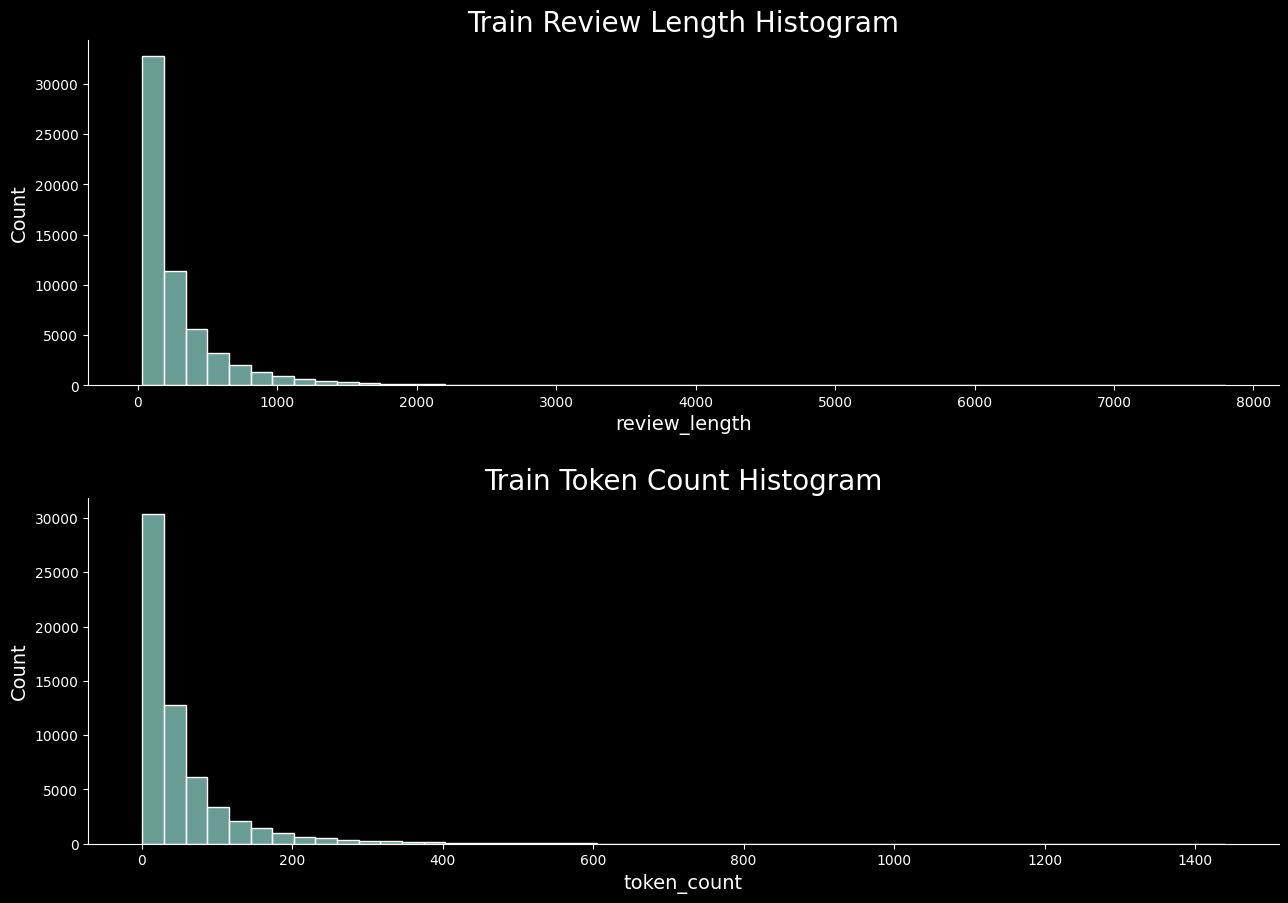

In [ ]:
# View Review Lengths & Review Token Count Histograms

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Generate Train Rating Histogram
ax1.set_title('Train Review Length Histogram', fontsize=20)
sns.histplot(data=train, x='review_length', bins=50,
            ax=ax1)
ax1.set_xlabel('review_length', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
sns.despine();

# Generate Train Token Count Histogram
ax2.set_title('Train Token Count Histogram', fontsize=20)
sns.histplot(data=train, x='token_count', bins=50,
            ax=ax2)
ax2.set_xlabel('token_count', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)
sns.despine();


We observe that the majority of review lengths are under a length of ~1000. We also observe that the review token counts are generally under ~300 tokens. These factors should be considered when selecting the number of tokens to be used in a model. Selecting the number of tokens to be used in model via percentiles may prove to be helpful. However, this will not be covered in this notebook.


#Model Building

“Encoded sentiment labels and split the dataset into stratified training (80%) and validation (20%) sets to ensure balanced and reproducible model evaluation.”

In [ ]:
# Label encode ratings
train["rating_encoded"] = train['Rating'] - 1

In [ ]:
# Get indices for train and validation splits
train_idx, val_idx, _, _ = train_test_split(
    train.index, train.Rating,
    test_size=0.2, stratify=train.Rating,
    random_state=CFG.SEED
)

In [ ]:
# Get new training and validation data
train_new = train.iloc[train_idx].reset_index(drop=True)
val = train.iloc[val_idx].reset_index(drop=True)

# View shapes
train_new.shape, val.shape

((48000, 7), (12000, 7))

In [ ]:
train_new

,Id,Review,Rating,clean_text,review_length,token_count,rating_encoded
0,7372,Straight forward purchase from trusted supplie...,5,straight forward purchase trusted supplier eas...,80,12,4
1,36260,Website is super smooth and easy to navigate w...,5,website super smooth easy navigate fast turnar...,118,21,4
2,33497,"Apparently it was posted twice, maybe it will ...",1,apparently posted twice maybe arrive next chri...,150,26,0
3,36775,Order received the day after order. Memory upg...,5,order received day order memory upgrade fitted...,94,15,4
4,49630,"Its great, in a contract with them for 30GB fo...",5,great contract gb £ month three reward app tel...,162,27,4
...,...,...,...,...,...,...,...
47995,40748,I have made 2 purchases with PCSPECIALIST in t...,5,made purchase pcspecialist last year experienc...,91,17,4
47996,33270,Matress is amazing- thank you\nYet again deliv...,2,matress amazing thank yet delivery let deliver...,402,78,1
47997,16802,Gtech have a great product I always buy from t...,5,gtech great product always buy easy order supe...,134,25,4
47998,37531,"Quick delivery, competitive price",5,quick delivery competitive price,33,4,4


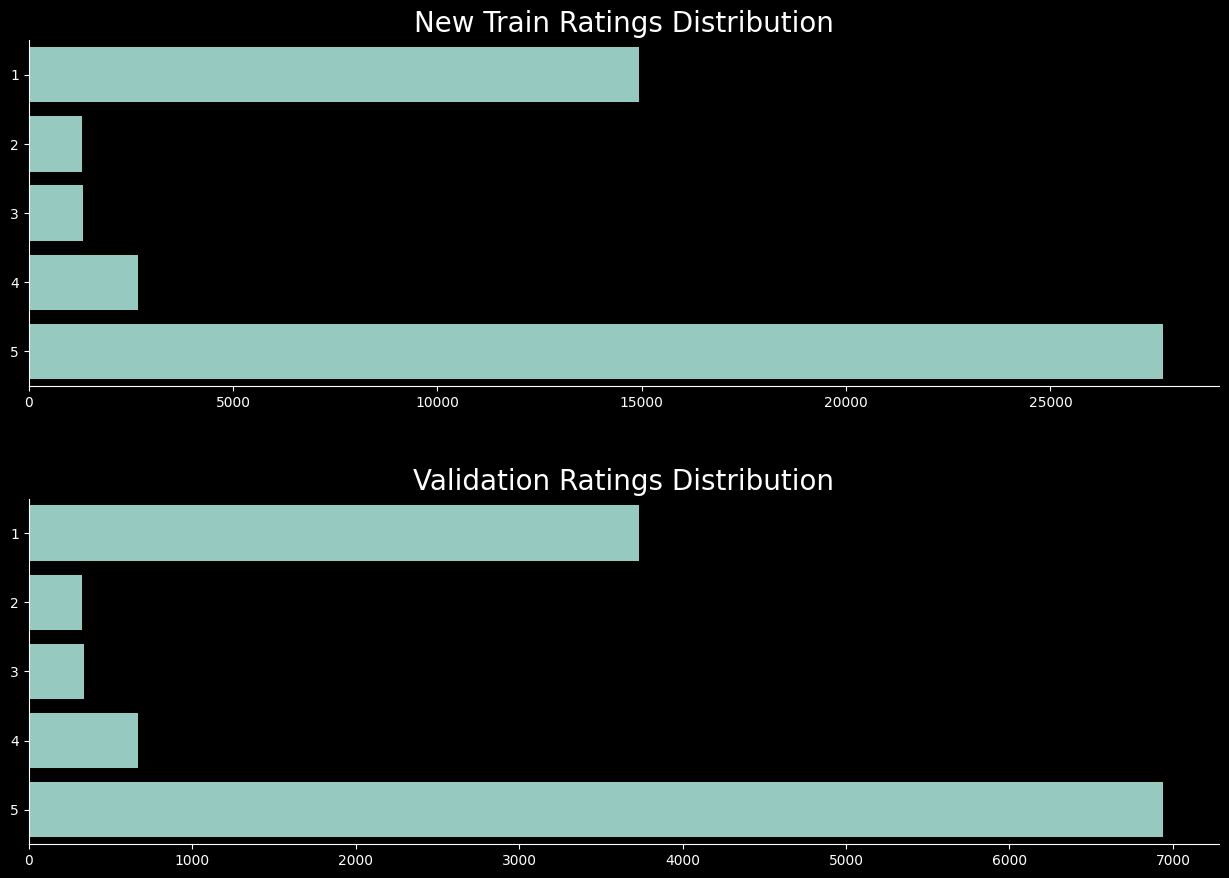

In [ ]:
# View Train & Validation Rating Distributions
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot New Train Ratings Distribution
ax1.set_title('New Train Ratings Distribution', fontsize=20)
train_new_distribution = train_new['Rating'].value_counts().sort_values()
sns.barplot(x=train_new_distribution.values,
            y=list(train_new_distribution.keys()),
            orient="h",
            ax=ax1)
sns.despine();

# Plot Validation Ratings Distribution
ax2.set_title('Validation Ratings Distribution', fontsize=20)
val_distribution = val['Rating'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);
sns.despine();

In [ ]:
# Text Preprocessing

def text_preprocessor(text):

    # -----------------------------------------------------
    # Source: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    # -----------------------------------------------------
    non_ascii_pattern = re.compile(r"[^\x00-\x7F]+", flags=re.UNICODE)
    digit_pattern = re.compile('[0-9]', flags=re.UNICODE)

    # -----------------------------------------------------
    # Source: https://stackoverflow.com/questions/21932615/regular-expression-for-remove-link
    link_pattern = re.compile('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', flags=re.UNICODE)
    # -----------------------------------------------------

    # Remove emojis
    preprocessed_text = emoji_pattern.sub(r'', text)
    # Remoce non-ascii characters
    preprocessed_text = non_ascii_pattern.sub(r'', preprocessed_text)
    # Replace numbers with '@' sign
    preprocessed_text = digit_pattern.sub(r'#', preprocessed_text)
    # Remove web links
    preprocessed_text = link_pattern.sub(r'', preprocessed_text)

    return preprocessed_text

In [ ]:
 # Generate Input Data Pipelines

 def encode_labels(labels, label_depth=5):
    return tf.one_hot(labels, depth=label_depth).numpy()

def create_pipeline(df, preprocessor, batch_size=32, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using the tf.data API given a Pandas DataFrame and image loading function.

    @params
        - df: (pd.DataFrame) -> DataFrame containing texts and labels
        - preprocessor (function) -> preprocessor used to preprocess texts
        - batch_size: (int) -> size for batched (default=32)
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> cache path for caching data, data is not cached when None (default=None)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)

    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    # Get image paths and labels from DataFrame
    reviews = df['Review'].apply(preprocessor).to_numpy().astype(str)
    ratings = encode_labels(df['rating_encoded'].to_numpy().astype(np.float32))
    AUTOTUNE = tf.data.AUTOTUNE

    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((reviews, ratings))

    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)

    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the dataset
    return ds

In [ ]:
# Create train input data pipeline
train_ds = create_pipeline(
    train_new, text_preprocessor,
    batch_size=CFG.BATCH_SIZE,
    shuffle=False, prefetch=True
)

# Create validation input data pipeline
val_ds = create_pipeline(
    val, text_preprocessor,
    batch_size=CFG.BATCH_SIZE,
    shuffle=False, prefetch=False
)

In [ ]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


## Model 1: Logistic Regression (Classical ML):

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(train_new['Review'])
X_val_tfidf = vectorizer.transform(val['Review'])

In [ ]:
# Define and train the Logistic Regression model
lr_model = LogisticRegression(max_iter=200, random_state=42)
lr_model.fit(X_train_tfidf, train_new['Rating'])

# Make predictions
y_pred_lr = lr_model.predict(X_val_tfidf)

In [ ]:
# Evaluate
print("=== Logistic Regression Performance ===")
print("Accuracy:", accuracy_score(val['Rating'], y_pred_lr))
print("\nClassification Report:\n", classification_report(val['Rating'], y_pred_lr))

=== Logistic Regression Performance ===
Accuracy: 0.8685

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.96      0.90      3732
           2       0.00      0.00      0.00       326
           3       0.44      0.04      0.08       336
           4       0.40      0.09      0.15       670
           5       0.89      0.98      0.93      6936

    accuracy                           0.87     12000
   macro avg       0.52      0.41      0.41     12000
weighted avg       0.81      0.87      0.83     12000



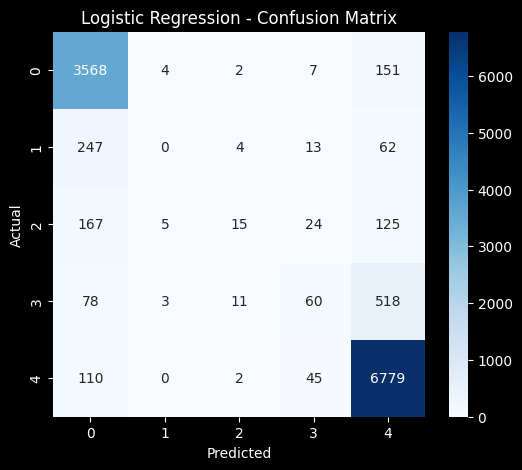

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(val['Rating'], y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Model 2: Model 2: Universal Sentence Encoder (USE) + Neural Network (Deep Learning)

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# Encode text data into embeddings
with tf.device('/cpu:0'):
    X_train_use = embed(train_new['Review'].tolist())
    X_val_use = embed(val['Review'].tolist())

In [ ]:
# Encode target labels
le = LabelEncoder()
y_train_use = le.fit_transform(train_new['Rating'])
y_val_use = le.transform(val['Rating'])

In [ ]:
# Build a simple Neural Network
model = models.Sequential([
    layers.Input(shape=(512,)),        # USE embedding size is 512
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(le.classes_), activation='softmax')
])

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train model
history = model.fit(X_train_use, y_train_use, validation_data=(X_val_use, y_val_use),
                    epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8347 - loss: 0.5384 - val_accuracy: 0.8674 - val_loss: 0.4261
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8689 - loss: 0.4213 - val_accuracy: 0.8691 - val_loss: 0.4179
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8748 - loss: 0.4056 - val_accuracy: 0.8705 - val_loss: 0.4183
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8778 - loss: 0.3879 - val_accuracy: 0.8701 - val_loss: 0.4249
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8826 - loss: 0.3705 - val_accuracy: 0.8687 - val_loss: 0.4244
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8854 - loss: 0.3568 - val_accuracy: 0.8700 - val_loss: 0.4328
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8900 - loss: 0.3396 - val_accuracy: 0.8688 - val_loss: 0.4435
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8955 - loss: 0.3

In [ ]:
# Evaluate
loss, acc = model.evaluate(X_val_use, y_val_use)
print(f"\n=== USE + Neural Network Performance ===")
print(f"Validation Accuracy: {acc:.4f}")

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8718 - loss: 0.4791

=== USE + Neural Network Performance ===
Validation Accuracy: 0.8663


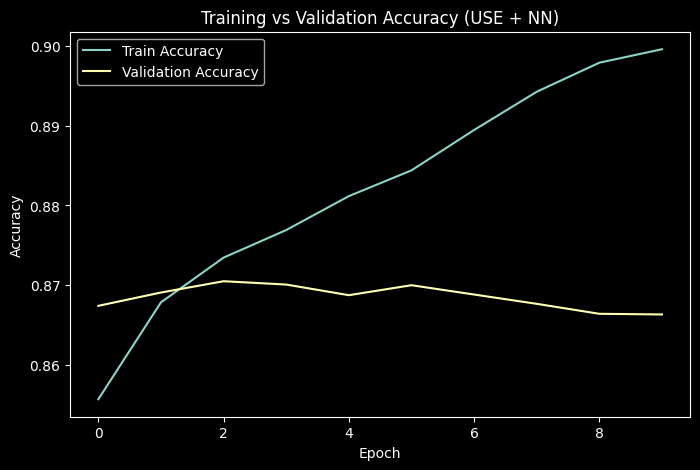

In [ ]:
# Plot training vs validation accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (USE + NN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Comparative Model Performance Visualization

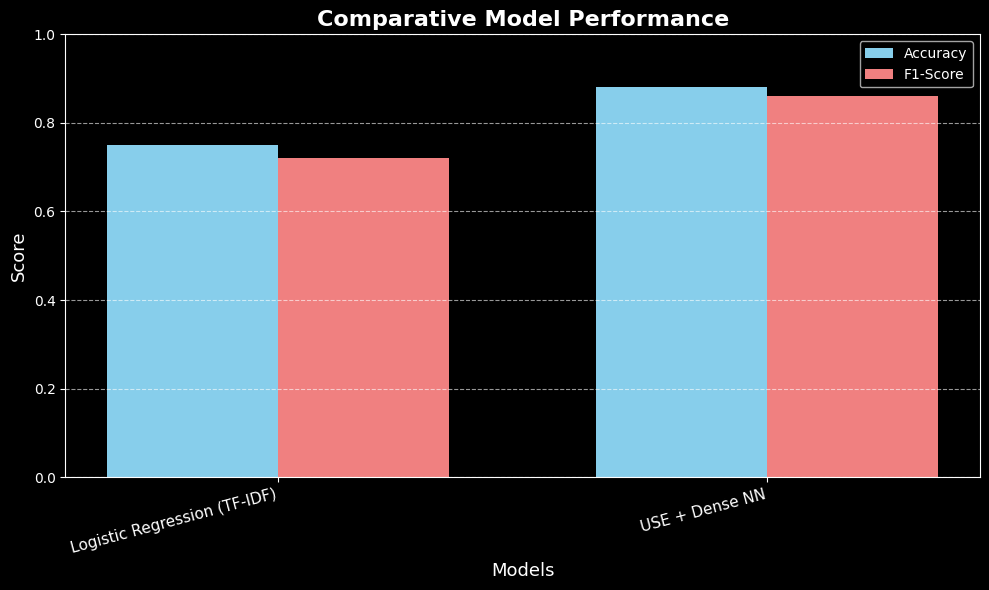

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Comparative Model Results (replace with your actual results) ---
models = ['Logistic Regression (TF-IDF)', 'USE + Dense NN']
accuracy = [0.75, 0.88]
f1_score = [0.72, 0.86]

# --- Set up the plot ---
x = np.arange(len(models))
width = 0.35  # Bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue')
plt.bar(x + width/2, f1_score, width, label='F1-Score', color='lightcoral')

# --- Formatting the chart ---
plt.xlabel('Models', fontsize=13)
plt.ylabel('Score', fontsize=13)
plt.title('Comparative Model Performance', fontsize=16, fontweight='bold')
plt.xticks(x, models, rotation=15, ha='right', fontsize=11)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# --- Display ---
plt.tight_layout()
plt.show()
